Install Required Libraries

In [ ]:
pip install pandas numpy tensorflow seaborn matplotlib wordcloud scikit-learn xgboost joblib streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import streamlit as st


In [ ]:
# Load dataset
messages = pd.read_csv("SMSSpamCollection", sep='\t', names=["label", "message"])

In [ ]:
# Data Cleaning and Preprocessing
messages.drop_duplicates(inplace=True)
messages['message'] = messages['message'].str.lower().str.replace('[^a-zA-Z0-9]', ' ')

<ipython-input-8-264f9e8ad885>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=messages['label'], palette='coolwarm')


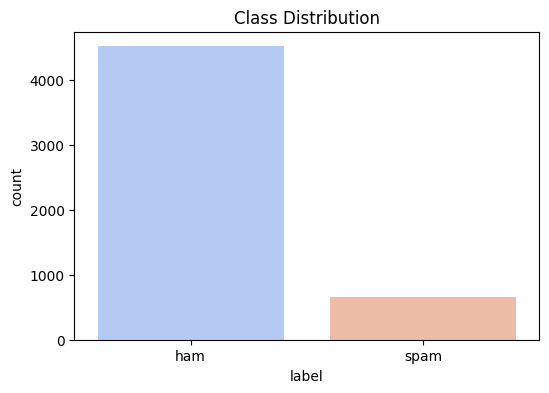

In [ ]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(6, 4))
sns.countplot(x=messages['label'], palette='coolwarm')
plt.title("Class Distribution")
plt.show()

In [ ]:
# WordClouds for Ham and Spam Messages
ham_msg_text = " ".join(messages[messages.label == 'ham']['message'])
spam_msg_text = " ".join(messages[messages.label == 'spam']['message'])

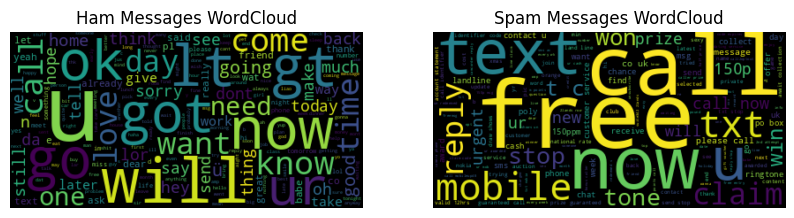

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(stopwords=STOPWORDS, background_color="black").generate(ham_msg_text), interpolation='bilinear')
plt.title("Ham Messages WordCloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(stopwords=STOPWORDS, background_color="black").generate(spam_msg_text), interpolation='bilinear')
plt.title("Spam Messages WordCloud")
plt.axis("off")

plt.show()

In [ ]:
# Encode labels
le = LabelEncoder()
messages['label'] = le.fit_transform(messages['label'])  # spam=1, ham=0

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(messages['message'], messages['label'], test_size=0.2, random_state=42)


In [ ]:
# Feature Engineering: TF-IDF and Count Vectorizer
tfidf = TfidfVectorizer()
count_vec = CountVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_train_count = count_vec.fit_transform(X_train)
X_test_count = count_vec.transform(X_test)

In [ ]:
# Train traditional ML models
nb = MultinomialNB()
rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
gb = GradientBoostingClassifier()

nb.fit(X_train_tfidf, y_train)
rf.fit(X_train_tfidf, y_train)
xgb.fit(X_train_tfidf, y_train)
gb.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:30:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GradientBoostingClassifier()

In [ ]:
# Train LSTM Model
max_words = 5000
max_len = 100

In [ ]:

# Tokenization
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

In [ ]:
# Define LSTM model with GRU layers
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    GRU(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_seq, y_train, epochs=15, batch_size=32, validation_data=(X_test_seq, y_test))

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


130/130 ━━━━━━━━━━━━━━━━━━━━ 63s 430ms/step - accuracy: 0.8935 - loss: 0.2948 - val_accuracy: 0.9700 - val_loss: 0.0921
Epoch 2/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 81s 428ms/step - accuracy: 0.9878 - loss: 0.0453 - val_accuracy: 0.9816 - val_loss: 0.0600
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 83s 435ms/step - accuracy: 0.9977 - loss: 0.0140 - val_accuracy: 0.9865 - val_loss: 0.0581
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 81s 431ms/step - accuracy: 0.9990 - loss: 0.0067 - val_accuracy: 0.9884 - val_loss: 0.0572
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 86s 463ms/step - accuracy: 0.9988 - loss: 0.0062 - val_accuracy: 0.9845 - val_loss: 0.0668
Epoch 6/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 80s 449ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9700 - val_loss: 0.1502
Epoch 7/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 80s 433ms/step - accuracy: 0.9989 - loss: 0.0070 - val_accuracy: 0.9845 - val_loss: 0.1005
Epoch 8/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 56s 431ms/step - accuracy: 0.9992 - loss: 8.9582e-04 -

In [ ]:

# Get LSTM predictions
lstm_preds = model.predict(X_test_seq).flatten()
lstm_preds = [1 if p > 0.5 else 0 for p in lstm_preds]

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step


In [ ]:
# Create ensemble model (Stacking + Boosting)
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from xgboost import XGBClassifier

# Wrapper class to make XGBClassifier compatible with StackingClassifier
class XGBClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **params):
        self.xgb = XGBClassifier(eval_metric='logloss', **params)

    def fit(self, X, y):
        self.xgb.fit(X, y)
        self.classes_ = self.xgb.classes_
        return self

    def predict(self, X):
        return self.xgb.predict(X)

    def predict_proba(self, X):
        return self.xgb.predict_proba(X)

# Initialize wrapped XGBoost model
xgb_wrapped = XGBClassifierWrapper()

# Create the stacking classifier
stacking = StackingClassifier(
    estimators=[('nb', nb), ('rf', rf), ('xgb', xgb_wrapped), ('gb', gb)],
    final_estimator=LogisticRegression(),
    passthrough=True  # Allows original features to be used by the final estimator
)

# Fit the stacking classifier
stacking.fit(X_train_tfidf, y_train)


StackingClassifier(estimators=[('nb', MultinomialNB()),
                               ('rf',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=42)),
                               ('xgb', XGBClassifierWrapper()),
                               ('gb', GradientBoostingClassifier())],
                   final_estimator=LogisticRegression(), passthrough=True)

In [ ]:
# Evaluate models
ml_preds = stacking.predict(X_test_tfidf)
ensemble_preds = [(lstm_preds[i] + ml_preds[i]) // 2 for i in range(len(ml_preds))]

In [ ]:
# Model Evaluation
print("LSTM Accuracy:", accuracy_score(y_test, lstm_preds))
print("ML Ensemble Accuracy:", accuracy_score(y_test, ml_preds))
print("Final Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds))
print("Classification Report:")
print(classification_report(y_test, ensemble_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, ensemble_preds))

LSTM Accuracy: 0.9825918762088974
ML Ensemble Accuracy: 0.9845261121856866
Final Ensemble Accuracy: 0.9845261121856866
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       894
           1       1.00      0.89      0.94       140

    accuracy                           0.98      1034
   macro avg       0.99      0.94      0.97      1034
weighted avg       0.98      0.98      0.98      1034

Confusion Matrix:
[[894   0]
 [ 16 124]]


In [ ]:
# Save models
joblib.dump(stacking, "stacking_model.pkl")
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w") as json_file:
    json_file.write(tokenizer_json)